# Testing Machine Unlearning against Gaussian data poisoning

This is a sample implementation of gaussian data poisoning as described by the AI Security paper [Machine Unlearning Fails to Remove Data Poisoning Attacks
](https://arxiv.org/abs/2406.17216).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

# For reproducibility. Remove this for performance.
torch.manual_seed(0)
np.random.seed(0)

Pick the most powerful device available.

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Let's define the function to be learned here. For now, we start with a linear function.

In [3]:
# Dimensions of linear regression
# TODO: change the dimensions
n = 1
p = 1
# Input shape
in_shape = (p,)
# Output shape
out_shape = (n,)

# The true parameters of the function to be learned by the model.
weights = torch.rand(n, p, device=device)
bias = torch.rand(n, device=device)

def f(x: torch.Tensor) -> torch.Tensor:
    """
    Returns an vector of length `n` from a vector of length `p`.
    
    This is the function to be learned.

    NOTE: this function can also be applied in batch by calling `f(X_batch)`
    where `X_batch` has a shape of the form `(N_batch, p)`.
    """
    return x @ weights.T + bias

### Generate the dataset

We start by generating the clean, non-poisoned features.

In [4]:
from torch.utils.data import TensorDataset, DataLoader

N = 10_000
bs = 50

# TODO: see if data poisoning is affected by a specific initialization
X_base = torch.rand((N, *in_shape), device=device)
print('Clean samples:', X_base.shape)

Clean samples: torch.Size([10000, 1])


### Poison the training samples

The attacker poisons a fraction $\varepsilon$ of the features with noise $(\xi_z)_{z \in S_\mathrm{poison}}$ and stores the noise for future usage.

In [5]:
poison_budget = 0.02
N_poison = int(poison_budget * N)
N_clean = N - N_poison
epsilon = 0.05

std_noise = epsilon * X_base.std().item()
noise = torch.normal(0, std_noise, size=(N_poison, *in_shape), device=device)
# Another independent noise used as a baseline for unlearning evaluation
# (not used to corrupt the dataset)
dummy_noise = torch.normal(0, std_noise, size=(N_poison, *in_shape), device=device)

print('Poisons:', noise.shape)

# QUESTION: spread poison on the whole dataset or on the train dataset?
# TODO: use subset for performance
X_to_poison = X_base[:N_poison]
X_poison = X_to_poison + noise
X_clean = X_base[N_poison:]
X_corrupted = torch.concat((X_poison, X_clean))


Poisons: torch.Size([200, 1])


Data poisoning creates a non-zero correlation between the poisoned data and the noise.

In [6]:
# Estimate correlation between the `kx` coordinate of the samples `X`
# and the `ky` coordinate of the samples `Y`.
def correlation(X: torch.Tensor, Y: torch.Tensor, kx=0, ky=0):
    return np.corrcoef(np.array(X[:, kx].cpu()), np.array(Y[:, ky].cpu()), rowvar=False)

print(
    'Correlation matrix of clean samples and noise\n',
    correlation(X_to_poison, noise)
)
print(
    'Correlation matrix of poisoned samples and fresh noise\n',
    correlation(X_to_poison, dummy_noise)
)
print(
    'Correlation matrix of poisoned samples and poisons\n',
    correlation(X_poison, noise)
)

Correlation matrix of clean samples and noise
 [[1.         0.01275784]
 [0.01275784 1.        ]]
Correlation matrix of poisoned samples and fresh noise
 [[1.         0.07036226]
 [0.07036226 1.        ]]
Correlation matrix of poisoned samples and poisons
 [[1.         0.49303459]
 [0.49303459 1.        ]]


In [7]:
def subset_to_tensor(s: torch.utils.data.Subset):
    # FIXME (perf): We cannot call `torch.tensor()` directly on a Subset,
    # so we have convert the subset to a list. This is inefficient.
    l = torch.concat(list(s))
    return l.reshape((len(s), *s[0].shape))

# TODO: create dataset from Xy subset for performance
def generate_dataset(X: torch.Tensor):
    """
    Generate a dataset `(x, y)` by computing `y` from `x`,
    and split it into training and testing data.
    """
    N = len(X)
    N_train = int(0.75 * N)
    N_valid = N - N_train
    [X_train, X_valid] = torch.utils.data.random_split(X, [N_train, N_valid])
    X_train = subset_to_tensor(X_train)
    X_valid = subset_to_tensor(X_valid)

    y_train = f(X_train)
    y_valid = f(X_valid)

    print('Train data:', X_train.shape, y_train.shape)

    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    valid_ds = TensorDataset(X_valid, y_valid)
    valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

    return train_dl, valid_dl

The defender unknowingly collects corrupted data, which contains a small fraction of poisons.

In [8]:
train_dl, valid_dl = generate_dataset(X_corrupted)

Train data: torch.Size([7500, 1]) torch.Size([7500, 1])


In [9]:
def generate_attack_dataset(X_poison: torch.Tensor, noise: torch.Tensor):
    """
    Generate a dataset `(x_poison, noise, y)` by computing `y` from `x_poison`,
    and split it into training and testing data.
    """
    y = f(X_poison)
    ds = TensorDataset(X_poison, noise, y)
    return DataLoader(ds, batch_size=bs * 2, shuffle=True)

From now on, we consider the following scenario :
1. The defender trains the model on the corrupted dataset.
2. The defender realizes afterwards they have been poisoned, and is able to determine which part of the dataset has been corrupted.
3. The defender runs the unlearning algorithm on the poisoned dataset.

We may also study a stronger relaxation of step 2 with the hypothesis that the defender is able to determine the exact values of the poisons. This unrealistic scenario may be used to prove that Machine Unlearning is necessarily vulnerable to data poisoning. Indeed, if Machine Unlearning fails with such strong assumptions, we may conclude the effect of data poisoning on the model parameters is simply irreversible.

In [10]:
attack_dl = generate_attack_dataset(X_poison, noise)
dummy_attack_dl = generate_attack_dataset(X_poison, dummy_noise)

## The model architecture

We use a simple deep learning model with one hidden layer.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: study the impact of parameters / dimension ratio
        # on the model's robustness to poisoning

        # A standard regression model would have `n * p` parameters.
        # This model has `n * p + n^2` parameters, so it will most likely overfit.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(p, n),
            #nn.ReLU(),
            #nn.Linear(n, n),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
from torch.nn import functional as F
from torch import optim

epochs = 5
lr = 0.5

model = NeuralNetwork().to(device)
opt = optim.SGD(model.parameters(), lr=lr)

# We use MSE which is OK for linear regression purposes.
# FIXME: I haven't found a way to make `F.cross_entropy` work...
loss_func = F.mse_loss
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)


Standard train/test procedure defined below.

In [13]:

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        #print(batch, ((y - pred).abs()).mean())
        #print('\n')
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            batch_size = len(y)
            test_loss += loss_fn(pred, y).item() / batch_size
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

## Train the model

In [14]:
train(train_dl, model, loss_func, opt)

loss: 0.037667  [   50/ 7500]
loss: 0.000000  [ 5050/ 7500]


In [15]:
# FIXME: loss shouldn't be zero
test(valid_dl, model, loss_func)

Test Error: 
 Avg loss: 0.000000 



Considering that the dataset variables $(x, y)$ and the parameters $W$ and $b$ are roughly uniform in $[0, 1]$, this loss value is extremely small. Note that the model is already overfitting - if the model was just a linear regression, the loss value would be even smaller.

## Machine Unlearning

### Gradient Descent (GD)

> GD continues to train the model $\theta_{\mathrm{initial}}$ on the
remaining dataset $S_{\mathrm{train}} \setminus U$ by using gradient descent. In particular, we obtain $\theta_{\mathrm{updated}}$ via
> 
> $\theta_{t+1} \gets \theta_t − \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $\eta$ denotes the step size and $g_t$ denotes a (mini-batch) gradient computed for the the training
loss $\widehat{\mathbb{E}}_{(x,y) \in S_{\mathrm{train}} \setminus U} \left[l((x, y), \theta)\right]$ defined using the remaining dataset $S_{\mathrm{train}} \setminus U$, where $l$ is a loss function, e.g., cross-entropy loss, hinge loss, etc.

In [16]:
def unlearn_gd(model, loss_fn, optimizer):
    train_dl, _ = generate_dataset(X_clean)
    train(train_dl, model, loss_fn, optimizer)

### Gradient Ascent (GA)

> GA is an unlearning algorithm which attempts to remove the influence of the forget set $U$ from the trained model by simply reversing the gradient updates that contain information about $U$. In particular, we update via
> 
> $\theta_{t+1} \gets \theta_t + \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $g_t$ denotes a (mini-batch) gradient computed for the the training loss $\widehat{\mathbb{E}}_{(x,y) \in U} \left[l((x, y), \theta)\right]$ on the deletion
set.

In [17]:
def unlearn_ga(model, loss_fn, optimizer):
    train_dl, _ = generate_dataset(X_poison)
    # Reversing the sign of the loss function also reverses the sign of its gradient
    train(train_dl, model, lambda y1, y2: -loss_fn(y1, y2), optimizer)

## Evaluate the effect of Gaussian data poisoning

We follow the *Algorithm 3* in the original paper of Pawelczyk et al.

In [18]:
# FIXME: this does not seem to yield the correct distribution.
def gaussian_unlearning_score(model, loss_fn, attack_dl):
    """
    The gaussian unlearning score (GUS) is the mean of the values returned by this function.
    """
    EPSILON = 1e-8
    I_poison = torch.zeros(N_poison)
    i = 0
    model.eval()
    for X_b, noise_b, y_b in attack_dl:
        for X, noise, y in zip(X_b, noise_b, y_b):
            # TODO: compute the loss in batch for performance instead of
            # element-by-element computation
            X_base = (X - noise).clone().detach().requires_grad_(True)
            # FIXME: is this the correct formula?
            loss = loss_fn(model(X_base), y)
            loss.backward()
            g = X_base.grad
            g_n = g.norm()
            if (g_n > EPSILON):
                I_poison[i] = noise.dot(g) / (std_noise * g_n)
            else:
                print('Abnormally zero gradient. This should not happen')
            i += 1
    return I_poison

In [19]:
from scipy import stats

def evaluate_unlearning(model, loss_fn, attack_dl, xi_name=r'$\xi$', g_name='g'):
    I_poison = gaussian_unlearning_score(model, loss_fn, attack_dl)
    mean = I_poison.mean()
    std = I_poison.std()

    plt.hist(I_poison, density=True)

    iz = np.linspace(I_poison.min(), I_poison.max())
    distr = stats.norm(mean, std)
    plt.plot(iz, distr.pdf(iz), label=fr'Gaussian fit: $\mathcal{{N}}({mean:.3}, {std:.3})$')
    distr = stats.norm(0.0, 1.0)
    plt.plot(iz, distr.pdf(iz), label=fr'Theory: $\mathcal{{N}}(0, 1)$')

    plt.xlabel(fr'$\mathcal{{I}}_{{\mathrm{{poison}}}} = \frac{{\langle \xi, {g_name} \rangle}}{{\epsilon ||{g_name}||_2}}$')
    plt.title(fr'Normalized dot product distribution between input gradients ${g_name}$ and {xi_name}')
    plt.legend()
    plt.show()

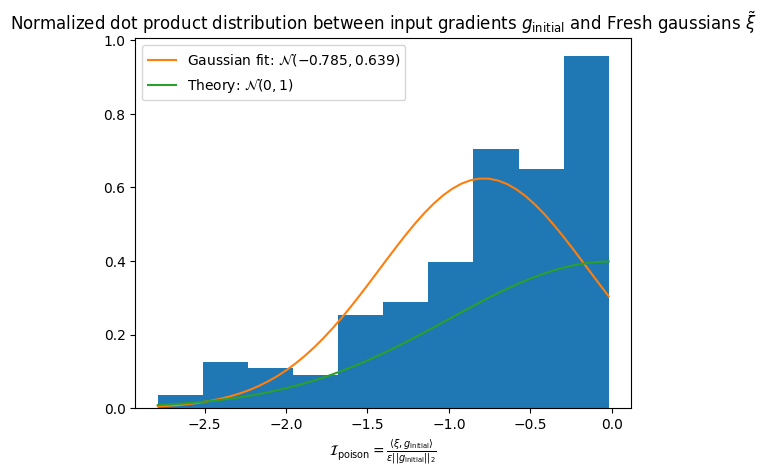

In [20]:
evaluate_unlearning(
    model, loss_func, dummy_attack_dl,
    xi_name=r'Fresh gaussians $\tilde{\xi}$', g_name=r'g_{\mathrm{initial}}',
)

For fresh Gaussians, the distribution should be centered around $0$.

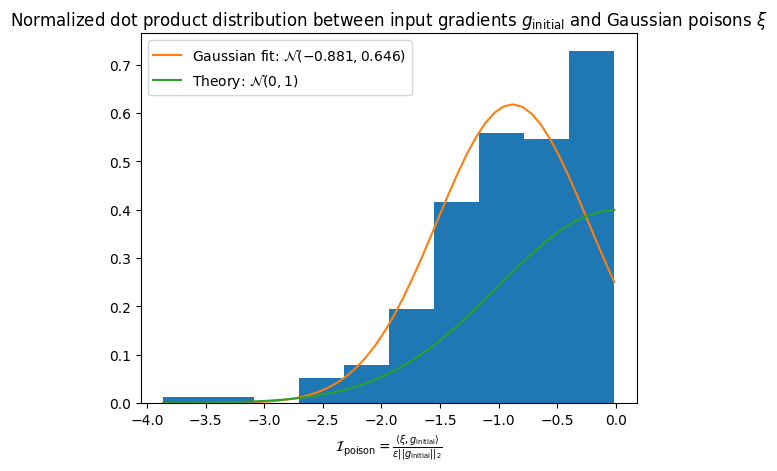

In [21]:
evaluate_unlearning(
    model, loss_func, attack_dl,
    xi_name=r'Gaussian poisons $\xi$',
    g_name=r'g_{\mathrm{initial}}',
)

Due to data poisoning, the model gradients are influenced by $\xi$ so the distribution is shifted.

Train data: torch.Size([150, 1]) torch.Size([150, 1])
loss: -0.000000  [   50/  150]


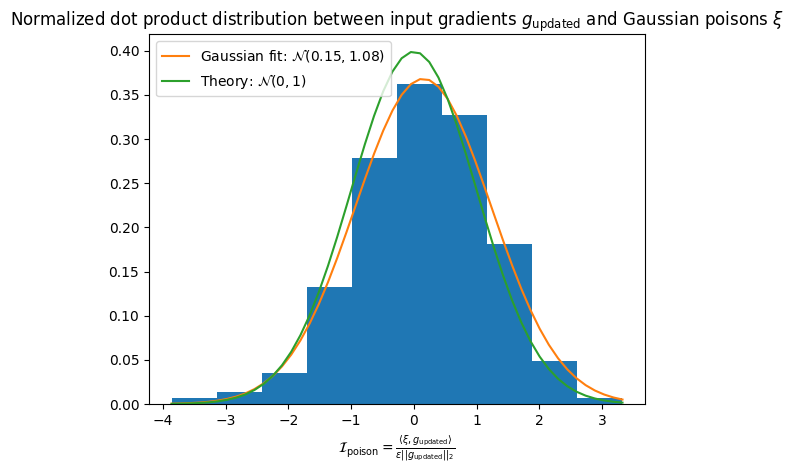

In [22]:
unlearn_ga(model, loss_func, opt)
evaluate_unlearning(
    model, loss_func, attack_dl,
    xi_name=r'Gaussian poisons $\xi$',
    g_name=r'g_{\mathrm{updated}}'
)

If the distribution is still shifted, that means the model did not perfectly unlearn the poisons.